# Fine-tuning of a model for segmentation of retinal optical coherence tomography images (AROI)

For more info, check the README.md file.

This notebook loads all the patient images. For each labeled retinal optical coherence tomography image, there are at least the following files:

* The original raw image
* The image labeled with colours
* The image labeled with numbers

The result is a list 'patient_images' containing PatientImage objects.

## Citations

Information about the dataset can be found in the following publications:

M. Melinščak, M. Radmilović, Z. Vatavuk, and S. Lončarić, "Annotated retinal optical coherence tomography images (AROI) database for joint retinal layer and fluid segmentation," Automatika, vol. 62, no. 3, pp. 375-385, Jul. 2021. doi: 10.1080/00051144.2021.1973298

M. Melinščak, M. Radmilović, Z. Vatavuk, and S. Lončarić, "AROI: Annotated Retinal OCT Images database," in 2021 44th International Convention on Information, Communication and Electronic Technology (MIPRO), Sep. 2021, pp. 400-405. 

M. Melinščak, "Attention-based U-net: Joint segmentation of layers and fluids from retinal OCT images," in 2023 46th International Convention on Information, Communication and Electronic Technology (MIPRO), Sep. 2021, pp. 391-396. 

In [1]:
from pathlib import Path
import os
import random
import torch
import numpy as np
import io
import requests
from collections import defaultdict
from PIL import Image
from typing import List, Dict, Tuple, cast
import datasets
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from matplotlib.figure import Figure
from matplotlib.patches import Patch

from transformers import AutoImageProcessor, DetrForSegmentation, SegformerImageProcessor
from transformers import AutoModelForSemanticSegmentation, TrainingArguments, Trainer
from transformers.image_transforms import rgb_to_id
from transformers import EvalPrediction
import evaluate

In [2]:
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

The retinal optical coherence tomography images dataset consists of a rar file. Unpack this file and you'll get a directory "AROI - online", containing two directories:

* 24 patient: the raw and labeled images of 24 patients
* inter_intra: analysis of differences in labeling by the experts, not used for fine-tuning a segmentation model

In [3]:
aroi_base_dir: Path = Path('AROI - online')
aroi_patients_dir: Path = aroi_base_dir / '24 patient'

The following dictionaries are only used when checking the images in the dataset:
* The labeled images with a colour mask should contain only 8 colours.
* The labeled images with a number mask should only contain 8 numbers.

Spoiler alert: all labeled images in the dataset have values limited to these dictionaries, as required.

In [4]:
colour_mask_image_colours: Dict[Tuple[int,int,int,int],str] = {
    (0, 0, 0, 255): 'black',
    (255, 0, 0, 255): 'red',
    (255, 255, 0, 255): 'yellow',
    (255, 255, 255, 255): 'white',
    (0, 0, 255, 255): 'blue',
    (0, 255, 255, 255): 'aqua',
    (255, 0, 255, 255): 'magenta',
    (0, 255, 0, 255): 'lime',
}
number_mask_image_values: Dict[int,str] = {
    0: 'above internal limiting membrane',
    1: 'internal limiting membrane-inner plexiform layer/inner nuclear layer',
    2: 'inner plexiform layer/inner nuclear layer-retinal pigment epithelium',
    3: 'retinal pigment epithelium/bruch membrane complex',
    4: 'under brunch membrane complex',
    5: 'pigment epithelial detachment',
    6: 'subretinal fluid',
    7: 'intraretinal fluid',
}

A class which represents some info about a single raw image and its labeled images, containing the following fields:
* width: always 512
* height: always 1024
* raw_path: the path of the unlabeled / original image
* colour_mask_path: the path of the labeled image with a colour mask
* number_mask_path: the path of the labeled image with a number mask
* patient_number: the number of the patient (there are 24 patients)
* image_number: the number of the image, which is only unique per patient
* get_raw_image_as_rgb(): return a path for the original image but converted to RGB

Quite some checks are done:
* Correct width and height
* Expected mode (RGBA / RGB / Greyscale / ...):
  * The unlabeled images have mode 'P': 8-bit pixels, mapped to any other mode using a colour palette
  * The colour mask images have mode 'RGBA': 4x8-bit pixels, true color with transparency mask
  * The number mask images have mode 'L': 8-bit pixels, grayscale
* Optionally, the colour or number of all pixels of all labeled images are checked against the above dictionaries

In [5]:
class PatientImage:
    # The expected width and height of all the images
    width: int = 512
    height: int = 1024

    def __init__(self, raw_path: Path, colour_mask_path: Path,
                 number_mask_path: Path,
                 check_pixel_values: bool, patient_number: int,
                 image_number: int):
        """ paths to the unlabelled image, the colour mask image, the
        number mask image and the ID of the patient such as 'patient14'
        The 3 images should have the same size.
        The unlabelled image should have mode 'P': 8-bit pixels, mapped to any other mode using a colour palette
        The colour mask image should have mode 'RGBA': 4x8-bit pixels, true color with transparency mask
        The number mask image should have mode 'L': 8-bit pixels, grayscale
        image_number values are only unique per patient
        """
        def is_file_and_exists(path: Path) -> None:
            if not path.exists():
                raise ValueError(f"{path} doesn't exist")
            if not path.is_file():
                raise ValueError(f"{path} is not a file")
        def check_mode_of_image(image: Image.Image, path: Path, expected_mode: str):
            if image.mode != expected_mode:
                raise ValueError(f"{path} does not have mode {expected_mode}: {image.mode}")
        def check_images_have_same_size(img1: Image.Image, path1: Path, img2: Image.Image, path2: Path):
            if img1.width != img2.width or \
                img1.height != img2.height:
                raise ValueError(f"{path1} and {path2} sizes do not match")
        self.raw_path: Path = raw_path
        self.colour_mask_path: Path = colour_mask_path
        self.number_mask_path: Path = number_mask_path
        self.image_number: int = image_number
        self.patient_number: int = patient_number
        # Make sure the files exist
        is_file_and_exists(self.raw_path)
        is_file_and_exists(self.colour_mask_path)
        is_file_and_exists(self.number_mask_path)
        # Make sure the images can be loaded as a PIL image
        raw_image: Image.Image = Image.open(raw_path)
        colour_mask_image: Image.Image = Image.open(colour_mask_path)
        number_mask_image: Image.Image = Image.open(number_mask_path)
        # Make sure the images all use the expected mode
        check_mode_of_image(raw_image, self.raw_path, 'P')
        check_mode_of_image(colour_mask_image, self.colour_mask_path, 'RGBA')
        check_mode_of_image(number_mask_image, self.number_mask_path, 'L')
        # Make sure the sizes match
        check_images_have_same_size(raw_image, self.raw_path, colour_mask_image, self.colour_mask_path)
        check_images_have_same_size(raw_image, self.raw_path, number_mask_image, self.number_mask_path)
        # apparently all images of all patients have the same size, check if it matches:
        if PatientImage.width != raw_image.width or PatientImage.height != raw_image.height:
            raise ValueError(f"Width {raw_image.width} and height {raw_image.height} are not the expected values")
        # check the number of colours used by the colour mask image and the number mask image
        x: int
        y: int
        if check_pixel_values:
            for x in range(0, colour_mask_image.width):
                for y in range(0, colour_mask_image.height):
                    colour_mask_pixel_colour: Tuple[int,int,int,int] = colour_mask_image.getpixel((x,y))
                    if colour_mask_pixel_colour not in colour_mask_image_colours:
                        raise ValueError("Unexpected colour for pixel in the colour mask image: " + str(colour_mask_pixel_colour))
                    number_mask_pixel_number: int = number_mask_image.getpixel((x,y))
                    if number_mask_pixel_number not in number_mask_image_values:
                        raise ValueError("Unexpected number in number mask image: " + str(number_mask_pixel_number))

    def get_raw_image_as_rgb(self) -> Path:
        """ Create an RGB version of the raw image as it's required for the HuggingFace dataset """
        # raw_path is something like [...]/patient16/raw/labeled/patient16_raw0027.png
        # let's make a path like [...]/patient16/raw/labeled_rgb/patient16_raw0027.png
        rgb_path: Path = Path(self.raw_path.parents[1], 'labeled_rgb', self.raw_path.name)
        os.makedirs(rgb_path.parent, exist_ok=True)
        Image.open(self.raw_path).convert(mode='RGB').save(rgb_path, format='PNG')
        return rgb_path

    def __str__(self) -> str:
        """ return some info about the image """
        return f"Patient {self.patient_number}, image {self.image_number}"

Now scan the directories of each patient and create a list of PatientImage objects:

In [6]:
def load_patient_dirs(patients_dir: Path) -> List[PatientImage]:
    """ Scan the directories for the images that we'll use for the 
    image segmentation dataset """
    all_patient_images: List[PatientImage] = []

    short_dir: str # a directory name like 'patient12'
    for short_dir in os.listdir(patients_dir):
        patient_number: int = int(short_dir.replace('patient',''))
        full_patient_dir: Path = aroi_patients_dir / short_dir
        raw_labeled_dir: Path = full_patient_dir / 'raw/labeled'
        mask_colour_dir: Path = full_patient_dir / 'mask/colour'
        mask_number_dir: Path = full_patient_dir / 'mask/number'
        img: str # single image like 'patient13_raw0056.png'
        for img in os.listdir(raw_labeled_dir):
            if img[0] != ".":
                image_number: int = int(img.replace(f"patient{patient_number}_raw","").replace(".png", ""))
                pi: PatientImage = PatientImage(raw_labeled_dir / img,
                                                mask_colour_dir / img,
                                                mask_number_dir / img,
                                                False,
                                                patient_number,
                                                image_number)
            all_patient_images.append(pi)
    return all_patient_images

patient_images: List[PatientImage] = load_patient_dirs(aroi_patients_dir)

Let's check the contents of the list:

In [7]:
print(f"Number of PatientImage objects: {len(patient_images)}")
print(f"Info about some PatientImage object: {patient_images[42]}")

Number of PatientImage objects: 1137
Info about some PatientImage object: Patient 9, image 64


I only briefly skimmed through the first paper to have a basic understanding of the meaning of the colours. The meaning of each label should be:

In [8]:
annotations_short: List[str] = [
    'above ILM',
    'ILM-IPL/INL',
    'IPL/INL-RPE',
    'RPE-BM',
    'under BM',
    'PED',
    'SRF',
    'IRF',
]
annotations_long: List[str] = [
    'above internal limiting membrane',
    'internal limiting membrane-inner plexiform layer/inner nuclear layer',
    'inner plexiform layer/inner nuclear layer-retinal pigment epithelium',
    'retinal pigment epithelium/bruch membrane complex',
    'under bruch membrane complex',
    'pigment epithelial detachment',
    'subretinal fluid',
    'intraretinal fluid',
]

Let's add a method to show the contents of a single PatientImage entry:

In [9]:
def show_singe_patient_image(pi: PatientImage):
    print(pi)
    fig_height = 10
    fig_width = 20
    fig: Figure = plt.figure(figsize=(fig_height, fig_width))
    gs: GridSpec = GridSpec(2, 2)
    raw: np.ndarray = np.array(Image.open(pi.raw_path))
    ax1: Axes = fig.add_subplot(gs[0, 0])
    ax1.set_axis_off()
    ax1.imshow(raw)
    ax1.set_title("Raw image")

    colors = list(colour_mask_image_colours.values())
    patches_short = [Patch(color=colors[i], label=annotations_short[i]) for i in range(len(colors))]
    patches_long = [Patch(color=colors[i], label=annotations_long[i]) for i in range(len(colors))]
    
    colour_mask: np.ndarray = np.array(Image.open(pi.colour_mask_path))
    ax3: Axes = fig.add_subplot(gs[0, 1])
    ax3.set_axis_off()
    ax3.imshow(colour_mask)
    ax3.legend(handles=patches_short, loc='upper right')
    ax3.set_title("Colour mask, short descriptions")

    colour_mask: np.ndarray = np.array(Image.open(pi.colour_mask_path))
    ax4: Axes = fig.add_subplot(gs[1, 1])
    ax4.set_axis_off()
    ax4.imshow(colour_mask)
    ax4.legend(handles=patches_long, loc='upper right')
    ax4.set_title("Colour mask, with (too) long descriptions")

Let's show a random patient image:

Patient 9, image 64


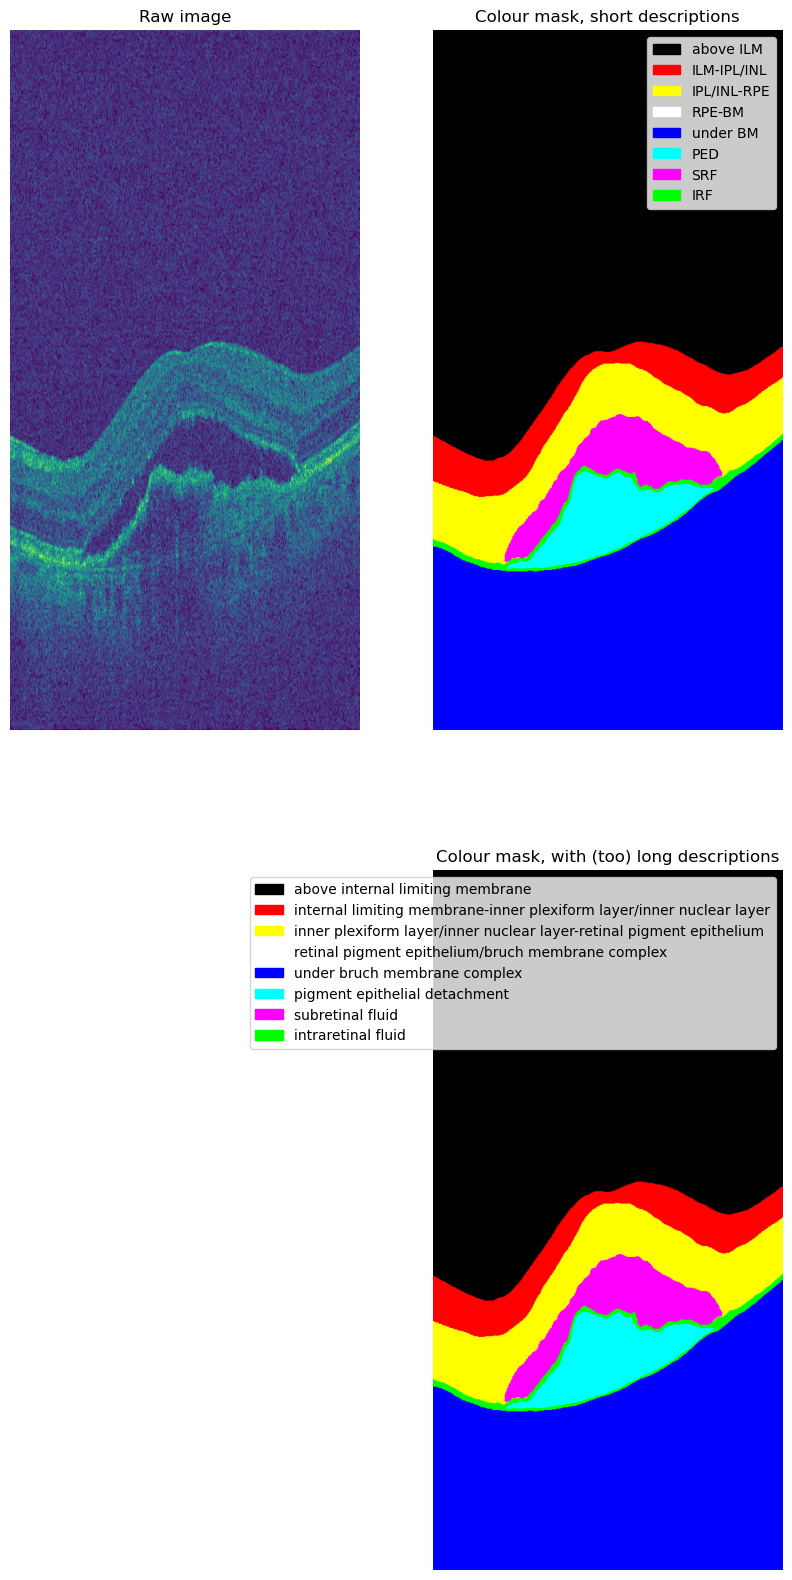

In [10]:
show_singe_patient_image(patient_images[42])

Another one:

Patient 22, image 47


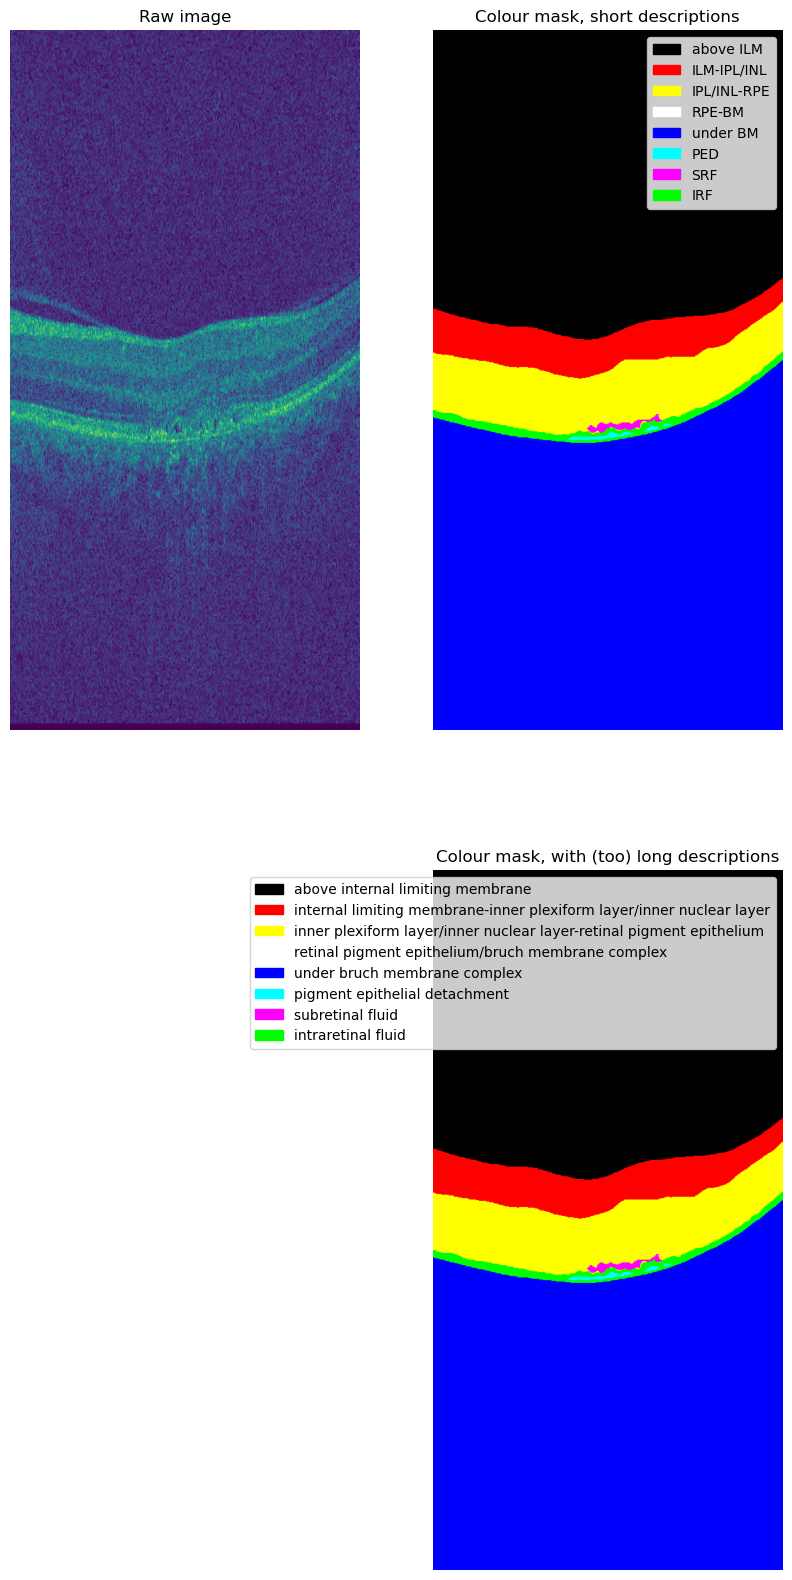

In [11]:
show_singe_patient_image(patient_images[500])